### How to create a good title for video?

In [104]:
import pandas as pd

videos = pd.read_csv('USvideos.csv')
videos.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


### What makes videos popular?

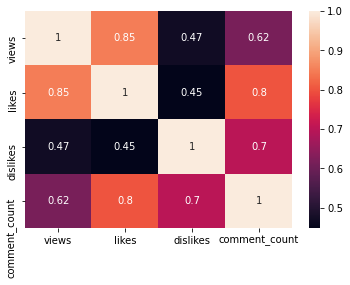

In [105]:
import seaborn as sn
import matplotlib.pyplot as plt


class CorrelationMatrix:
    def __init__(self, df):
        self.df = df

    def draw(self):
        corr_matrix = self.df[['views', 'likes', 'dislikes', 'comment_count']].corr()
        sn.heatmap(corr_matrix, annot=True)
        plt.show()


CorrelationMatrix(videos).draw()

In [106]:
class YoutubeNormalizer:

    def __init__(self, csv):
        self.csv = csv

    def decide_about_popular(self):
        lots_views = self.csv.views.quantile(0.8)
        comments_median = self.csv.comment_count.quantile(0.6)
        lots_of_dislike = self.csv.dislikes.quantile(0.8)
        self.csv['popular'] = 0
        self.csv.loc[(comments_median < self.csv.comment_count) & (self.csv.views > lots_views), 'popular'] = 1
        self.csv.loc[(self.csv.dislikes > lots_of_dislike) & (self.csv.likes > self.csv.dislikes), 'popular'] = 1

    def get_normalized_data(self):
        self.csv.drop_duplicates(subset="title", keep='first', inplace=True)
        self.decide_about_popular()
        title_with_popular = self.csv[['title', 'popular']]
        return title_with_popular


normalized_data = YoutubeNormalizer(videos).get_normalized_data()
normalized_data.head()

,title,popular
0,WE WANT TO TALK ABOUT OUR MARRIAGE,1
1,The Trump Presidency: Last Week Tonight with J...,1
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",1
3,Nickelback Lyrics: Real or Fake?,0
4,I Dare You: GOING BALD!?,1


### Title Normalization

In [107]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
import warnings

warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')

stop = stopwords.words('english')
st = PorterStemmer()


class NormalizedTitle:
    def __init__(self, df):
        self.df = df

    @staticmethod
    def avg_word(sentence):
        words = sentence.split()
        return sum(len(word) for word in words) / len(words)

    def parameters_extraction(self):
        self.df['word_count'] = self.df['title'].apply(lambda x: len(str(x).split(" ")))
        self.df['char_count'] = self.df['title'].str.len()
        self.df['avg_word'] = self.df['title'].apply(lambda x: self.avg_word(x))
        self.df['stopwords'] = self.df['title'].apply(lambda x: len([x for x in x.split() if x in stop]))
        self.df['hastags'] = self.df['title'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
        self.df['numerics'] = self.df['title'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))

    def text_preparation(self):
        self.df['title'] = self.df['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
        self.df['title'] = self.df['title'].str.replace('[^\w\s]', '')
        self.df['title'] = self.df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
        freq = pd.Series(' '.join(self.df['title']).split()).value_counts()
        common_words = freq[freq > 250]
        common_words = list(common_words.index)
        self.df['title'] = self.df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in common_words))
        rare_words = common_words = freq[freq < 5]
        rare_words = list(common_words.index)
        self.df['title'] = self.df['title'].apply(lambda x: " ".join(x for x in x.split() if x not in rare_words))
        self.df['title'] = self.df['title'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
        self.df['title'] = self.df['title'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

    def process(self):
        self.parameters_extraction()
        self.text_preparation()
        return self.df


normalized_title = NormalizedTitle(normalized_data).process()
normalized_title.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nowak\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nowak\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,popular,word_count,char_count,avg_word,stopwords,hastags,numerics
0,want talk marriag,1,7,34,4.0,0,0,0
1,trump last week tonight john oliv hbo,1,10,62,5.3,1,0,0
2,racist rudi mancuso king lele pon,1,10,53,4.4,0,0,0
3,lyric real fake,0,5,32,5.6,1,0,0
4,go,1,5,24,4.0,0,0,0


### Title Vectorization

In [108]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics, naive_bayes, svm, ensemble


class TitleVectorization:
    def __init__(self, df):
        self.df = df

    def process(self):
        train_df, test_df = train_test_split(
            self.df,
            test_size=0.1,
            stratify=self.df['popular'],
        )
        vectorizer = CountVectorizer(max_features=1000, lowercase=True, ngram_range=(1, 2), analyzer="word")
        vectorizer.fit(train_df)
        return train_df, test_df, vectorizer


(train_title_popularity, test_title_popularity, vectorizer) = TitleVectorization(normalized_title).process()

### Classification and metrics

In [109]:
class Classification:
    def __init__(self, train_df, test_df, vectorizer, strategy):
        self.train_df = train_df
        self.test_df = test_df
        self.vectorizer = vectorizer
        if strategy == 'LogisticRegression':
            self.model = LogisticRegression(class_weight='balanced', dual=False)
        elif strategy == 'NAIVE BAYES':
            self.model = naive_bayes.MultinomialNB()
        elif strategy == 'SVM':
            self.model = svm.SVC()
        elif strategy == 'RANDOM FORREST':
            self.model = ensemble.RandomForestClassifier()

    def train(self):
        transformed = vectorizer.transform(self.train_df['title'])
        self.model.fit(transformed, self.train_df['popular'])

    def show_model_statistic(self):
        vectorized = vectorizer.transform(self.test_df['title'])
        predicted = self.model.predict(vectorized)
        target = self.test_df['popular']
        print(metrics.classification_report(target, predicted, digits=4))

### Logistic Regression

In [110]:
logistic_regression_classification = Classification(train_df=train_title_popularity, test_df=test_title_popularity, vectorizer=vectorizer,
                                                    strategy='LogisticRegression')
logistic_regression_classification.train()
logistic_regression_classification.show_model_statistic()

              precision    recall  f1-score   support

           0     0.7601    1.0000    0.8637       491
           1     0.0000    0.0000    0.0000       155

    accuracy                         0.7601       646
   macro avg     0.3800    0.5000    0.4318       646
weighted avg     0.5777    0.7601    0.6564       646



### NAIVE BAYES

In [111]:
naive_bayes_classification = Classification(train_df=train_title_popularity, test_df=test_title_popularity, vectorizer=vectorizer,
               strategy='NAIVE BAYES')
naive_bayes_classification.train()
naive_bayes_classification.show_model_statistic()

              precision    recall  f1-score   support

           0     0.7601    1.0000    0.8637       491
           1     0.0000    0.0000    0.0000       155

    accuracy                         0.7601       646
   macro avg     0.3800    0.5000    0.4318       646
weighted avg     0.5777    0.7601    0.6564       646



### SVM

In [112]:
svm_classification = Classification(train_df=train_title_popularity, test_df=test_title_popularity, vectorizer=vectorizer,
               strategy='SVM')
svm_classification.train()
svm_classification.show_model_statistic()

              precision    recall  f1-score   support

           0     0.7601    1.0000    0.8637       491
           1     0.0000    0.0000    0.0000       155

    accuracy                         0.7601       646
   macro avg     0.3800    0.5000    0.4318       646
weighted avg     0.5777    0.7601    0.6564       646



### RANDOM FORREST

In [113]:
random_forest_tree = Classification(train_df=train_title_popularity, test_df=test_title_popularity, vectorizer=vectorizer,
               strategy='RANDOM FORREST')
random_forest_tree.train()
random_forest_tree.show_model_statistic()

              precision    recall  f1-score   support

           0     0.7601    1.0000    0.8637       491
           1     0.0000    0.0000    0.0000       155

    accuracy                         0.7601       646
   macro avg     0.3800    0.5000    0.4318       646
weighted avg     0.5777    0.7601    0.6564       646

